In [4]:
%load_ext autoreload
%autoreload 2

# add Code folder, if the package is not installed.
import sys
sys.path.append('../qdarts')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

# import main class and plotting function
from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes


# import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
# Define the system

#All capacitances are given in aF
N = 2#number of dots   

lambda_d = 0.5
lambda_g  = 0.5

avg_d = 10
avg_g = 20

sig_d = 2
sig_g = 2
C_DD = np.diag(np.random.normal(avg_d,sig_d, size = N))
C_m = np.sqrt(C_DD[0,0] * C_DD[1,1])*np.exp(-1/lambda_d)
C_DD[0,1] = C_m
C_DD = C_DD + C_DD.T #symmetrize

C_DG = np.diag(np.random.normal(avg_g,sig_g, size = N))
C_DG[0,1] = np.sqrt(C_DG[1,1] * C_DD[0,0])*np.exp(-1/lambda_g) 
C_DG[1,0] = np.sqrt(C_DG[0,0] * C_DD[1,1])*np.exp(-1/lambda_g)

# NOTE: we use the convention that tc is the energy gap at avoided crossing H = tc/2 sx
tunnel_couplings = np.zeros((N,N))
tunnel_couplings[0,1] = 1e-9999


In [7]:
capacitance_config = {
        "C_DD" : C_DD,  #dot-dot capacitance matrix
        "C_Dg" : C_DG,  #dot-gate capacitance matrix
        "ks" : None,       #distortion of Coulomb peaks. NOTE: If None -> constant size of Coublomb peak 
}

tunneling_config = {
        "tunnel_couplings": tunnel_couplings, #tunnel coupling matrix
        "temperature": 0.1,                   #temperature in Kelvin
        "energy_range_factor": 5,  #energy scale for the Hamiltonian generation. NOTE: Smaller -> faster but less accurate computation 
}
sensor_config = {
        "sensor_dot_indices": [],  #Indices of the sensor dots
        "sensor_detunings": [-0.0005],  #Detuning of the sensor dots
        "noise_amplitude": {"fast_noise":5*1e-5, "slow_noise": 5*1e-5}, #Noise amplitude for the sensor dots in eV
        "peak_width_multiplier": 50,  #Width of the sensor peaks in the units of thermal broadening m *kB*T/0.61.
}


In [8]:
# Create the experiment object from the configuration files
experiment = Experiment(capacitance_config, tunneling_config, sensor_config)

EXPERIMENT INITIALIZED
-----------------------


TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

In [ ]:
## CSD 
xexp, yexp, csd, polytopesexp, sensor_signalexp, _ = experiment.generate_CSD(
                                                plane_axes = np.array([[1,0],[0,1]
                                                            
                                                            ]), # vectors spanning the cut in voltage space
                                                #target 
                                                target_state = [1,0],
                                                target_transition = [-1,1],
                                                #transition from target state, here transition 
                                                #to [2,3,2,3,5,5]
                                                x_voltages=np.linspace(-0.01, 0.035, 100), #voltage range for x-axis
               
                                                y_voltages=np.linspace(-0.01, 0.035, 100), #voltage range for y-axis
                                                compute_polytopes = True
                                                )



In [ ]:
fig, ax = plt.subplots()

plt.pcolormesh(xexp, yexp, csd)
plot_polytopes(ax,polytopesexp, axes_rescale=1)  # plot the polytopes to see the constant occupation regions
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r"$V_1$")
plt.ylabel(r"$V_2$")

In [9]:
## Compute Maxwell capacitances:

C_DD_maxwell = np.zeros((N,N))
C_DG_maxwell = np.zeros((N,N))
for k in range(N):
    for l in range(N):
        if k==l:
            C_DD_maxwell[k,l] = np.sum(C_DD[k,:]+ C_DG[k,:]) 
        else:
            C_DD_maxwell[k,l] = -C_DD[k,l]
        
        C_DG_maxwell[k,l] = C_DG[k,l]
print(C_DD_maxwell)

[[50.04531604 -1.42883821]
 [-1.42883821 40.85908911]]


In [10]:
# Compute the size of Coulomb diamonds
C_DDinv = np.linalg.inv(C_DD_maxwell)  # C_DDmaxwel are the saem
e_aF = 1.6*1e-19/1e-18  #e/aF

dVx = C_DDinv[0,0]/(C_DDinv @ C_DG)[0,0]
dVy = C_DDinv[1,1]/(C_DDinv @ C_DG)[1,1]

dVx  = dVx* e_aF 
dVy  = dVy* e_aF 

#number of Coulomb peaks in the x and y direction
Nd = 5

In [937]:
## CSD 
xexp, yexp, csd, polytopesexp, sensor_signalexp, _ = experiment.generate_CSD(
                                                plane_axes = np.array([[1,0],[0,1]
                                                            
                                                            ]), # vectors spanning the cut in voltage space
                                                #target 
                                                target_state = [1,0],
                                                target_transition = [-1,1],
                                                #transition from target state, here transition 
                                                #to [2,3,2,3,5,5]
                                                x_voltages=np.linspace(-dVx, Nd*dVx, 100), #voltage range for x-axis
               
                                                y_voltages=np.linspace(-dVy, Nd*dVy
                                                , 100), #voltage range for y-axis
                                                compute_polytopes = True
                                                )



v_offset found: [0.00314419 0.00380989]


Text(0, 0.5, '$V_2/\\Delta V_\\diamond[2]$')

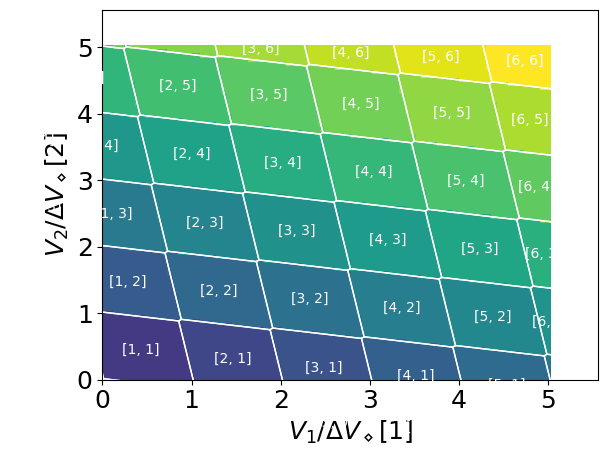

In [938]:
fig, ax = plt.subplots()

plt.pcolormesh(xexp, yexp, csd)
plot_polytopes(ax,polytopesexp, axes_rescale=1)  # plot the polytopes to see the constant occupation regions
plt.xticks(np.arange(0,Nd+1)*dVx)
plt.yticks(np.arange(0,Nd+1)*dVy)
plt.gca().set_xticklabels(np.arange(0,Nd+1))
plt.gca().set_yticklabels(np.arange(0,Nd+1))
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r"$V_1/\Delta V_\diamond[1]$")
plt.ylabel(r"$V_2/\Delta V_\diamond[2]$")

In [939]:
# Compute alpha

alpha =  np.linalg.inv(C_DD_maxwell) @ (C_DG_maxwell)
# inverse of the matrix
T = np.linalg.inv(alpha)


v1 = T @ np.array(np.array([1,0]))
v2 = T @ np.array(np.array([0,1]))


#Normalize
v1 = v1/np.linalg.norm(v1)
v2 = v2/np.linalg.norm(v2)

print(v1,v2)


[ 0.98329536 -0.18201713] [-0.15344268  0.98815755]


In [940]:
xexp, yexp, csd, polytopesexp, sensor_signalexp, _ = experiment.generate_CSD(
                                                plane_axes = np.array([v1,v2
                                                            
                                                            ]), # vectors spanning the cut in voltage space
                                                #target 
                                                target_state = [1,0],
                                                target_transition = [-1,1],
                                                #transition from target state, here transition 
                                                #to [2,3,2,3,5,5]
                                                x_voltages=np.linspace(-dVx, Nd*dVx, 100), #voltage range for x-axis
               
                                                y_voltages=np.linspace(-dVy, Nd*dVy
                                                , 100), #voltage range for y-axis
                                                compute_polytopes = True
                                                )



v_offset found: [0.00314419 0.00380989]


Text(0, 0.5, '$V_2/\\Delta V_\\diamond[2]$')

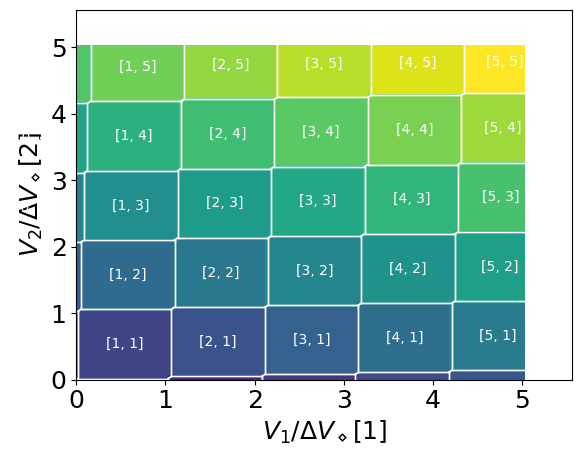

In [941]:
fig, ax = plt.subplots()

plt.pcolormesh(xexp, yexp, csd)
plot_polytopes(ax,polytopesexp, axes_rescale=1)  # plot the polytopes to see the constant occupation regions
plt.xticks(np.arange(0,Nd+1)*dVx)
plt.yticks(np.arange(0,Nd+1)*dVy)
plt.gca().set_xticklabels(np.arange(0,Nd+1))
plt.gca().set_yticklabels(np.arange(0,Nd+1))
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.xlabel(r"$V_1/\Delta V_\diamond[1]$")
plt.ylabel(r"$V_2/\Delta V_\diamond[2]$")